[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kevin7261/Geographic-Data-Science-with-Python/blob/main/區域空間自相關.ipynb)

# 區域空間自相關


## [1] 上傳資料

In [69]:
# @title <介面> 上傳geojson檔案

from google.colab import files
import os

def upload_geojson():
  print("請選擇要上傳的 geojson 檔案。若上傳同名檔案，將會自動覆寫。")
  uploaded = files.upload()
  for uploaded_filename in uploaded.keys():
    if uploaded_filename.endswith('.geojson'):
      # 檢查是否需要處理 Colab 自動重新命名的情況
      if uploaded_filename.endswith(').geojson'):
          # 嘗試找出原始檔名
          original_filename = uploaded_filename.rsplit('(', 1)[0].strip() + '.geojson'
          if os.path.exists(original_filename):
              os.remove(original_filename) # 刪除舊檔案
              print(f"Existing file '{original_filename}' overwritten.")
          # 將上傳的檔案重新命名為原始檔名
          os.rename(uploaded_filename, original_filename)
          print(f"已將 '{uploaded_filename}' 重新命名為 '{original_filename}'")
          return original_filename # 返回原始檔名
      else:
         # 如果沒有被自動重新命名，直接返回上傳的檔名
         print(f"已上傳檔案：{uploaded_filename}")
         return uploaded_filename

  print("沒有上傳有效的 geojson 檔案。")
  return None # 沒有上傳或上傳的不是 geojson

FILE_NAME_GEOJSON = upload_geojson()
print("實際檔名：", FILE_NAME_GEOJSON)

請選擇要上傳的 geojson 檔案。若上傳同名檔案，將會自動覆寫。


Saving 15_台南市區_合併位置.geojson to 15_台南市區_合併位置 (1).geojson
Existing file '15_台南市區_合併位置.geojson' overwritten.
已將 '15_台南市區_合併位置 (1).geojson' 重新命名為 '15_台南市區_合併位置.geojson'
實際檔名： 15_台南市區_合併位置.geojson


In [70]:
# @title <介面> 上傳xlsx檔案

from google.colab import files
import os

def upload_xlsx():
  print("請選擇要上傳的 xlsx 檔案。若上傳同名檔案，將會自動覆寫。")
  uploaded = files.upload()
  for uploaded_filename in uploaded.keys():
    if uploaded_filename.endswith('.xlsx'):
      # 檢查是否需要處理 Colab 自動重新命名的情況
      if uploaded_filename.endswith(').xlsx'):
          # 嘗試找出原始檔名
          original_filename = uploaded_filename.rsplit('(', 1)[0].strip() + '.xlsx'
          if os.path.exists(original_filename):
              os.remove(original_filename) # 刪除舊檔案
              print(f"Existing file '{original_filename}' overwritten.")
          # 將上傳的檔案重新命名為原始檔名
          os.rename(uploaded_filename, original_filename)
          print(f"已將 '{uploaded_filename}' 重新命名為 '{original_filename}'")
          return original_filename # 返回原始檔名
      else:
         # 如果沒有被自動重新命名，直接返回上傳的檔名
         print(f"已上傳檔案：{uploaded_filename}")
         return uploaded_filename

  print("沒有上傳有效的 xlsx 檔案。")
  return None # 沒有上傳或上傳的不是 xlsx

FILE_NAME_XLSX = upload_xlsx()
print("實際檔名：", FILE_NAME_XLSX)

請選擇要上傳的 xlsx 檔案。若上傳同名檔案，將會自動覆寫。


Saving 15_台南市區_合併位置.xlsx to 15_台南市區_合併位置 (1).xlsx
Existing file '15_台南市區_合併位置.xlsx' overwritten.
已將 '15_台南市區_合併位置 (1).xlsx' 重新命名為 '15_台南市區_合併位置.xlsx'
實際檔名： 15_台南市區_合併位置.xlsx


## [2] 初始設定

In [71]:
# @title 專案設定

PROJECT_NAME = "15_台南市區_合併位置"

WORKSHEET_NAME = "15_台南市區_合併位置"
ANALYSIS_FIELD_NAME = "count"
ANALYSIS_FIELD_NAME_LAG = f"{ANALYSIS_FIELD_NAME}_lag"
ANALYSIS_FIELD_NAME_BINARY = f"{ANALYSIS_FIELD_NAME}_binary"
ANALYSIS_FIELD_NAME_STD = f"{ANALYSIS_FIELD_NAME}_std"
ANALYSIS_FIELD_NAME_LAG_STD = f"{ANALYSIS_FIELD_NAME}_lag_std"

In [72]:
# @title 下載台北思源黑體

# 下載台北思源黑體，並隱藏輸出
!wget -q -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 匯入必要的庫
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 新增字體
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')

# 設定字體
mpl.rc('font', family='Taipei Sans TC Beta')


In [73]:
# @title 安裝套件

!pip install -q geopandas gdown
!pip install -q pysal splot contextily
!pip install -q rioxarray rasterio xarray

In [74]:
# @title 匯入函式庫

import matplotlib.pyplot as plt  # Graphics
from matplotlib import colors
import seaborn  # Graphics
import geopandas  # Spatial data manipulation
import pandas  # Tabular data manipulation
import rioxarray  # Surface data manipulation
import xarray  # Surface data manipulation
from pysal.explore import esda  # Exploratory Spatial analytics
from pysal.lib import weights  # Spatial weights
import contextily  # Background tiles

## [3] 資料處理

In [75]:
# @title 載入xlsx

ref = pandas.read_excel(FILE_NAME_XLSX, sheet_name=WORKSHEET_NAME).set_index("name")

#ref.head()

In [76]:
# @title 載入geojson

lads = geopandas.read_file(
    FILE_NAME_GEOJSON,
).set_index("CODEBASE")
#lads.info()

#print(lads.crs) # EPSG:4979 Geodetic 3D coordinate system

lads.set_crs(epsg=3826, inplace=True, allow_override=True) # EPSG:3826 TWD97

#print(lads.crs)

,U_ID,CODE1,CODE2,TOWN_ID,TOWN,COUNTY_ID,COUNTY,X,Y,AREA,geometry
CODEBASE,,,,,,,,,,,
A6733-0874-00,5144,A6733-43-012,A6733-43,67000330,南區,67000,臺南市,166172.65021,2.535587e+06,25735.24733,"POLYGON Z ((166321.261 2535692.982 0, 166319 2..."
A6733-0878-00,5145,A6733-44-006,A6733-44,67000330,南區,67000,臺南市,165903.12757,2.535458e+06,73573.78885,"POLYGON Z ((165968.38 2535639.042 0, 165978.83..."
A6733-0876-00,5146,A6733-43-012,A6733-43,67000330,南區,67000,臺南市,166223.37937,2.535525e+06,20277.53652,"POLYGON Z ((166317.999 2535628.685 0, 166318.5..."
A6732-0998-00,4736,A6732-60-005,A6732-60,67000320,東區,67000,臺南市,171126.85822,2.540743e+06,12151.50679,"POLYGON Z ((171065.623 2540812.968 0, 171117.3..."
A6733-0546-00,4737,A6733-28-006,A6733-28,67000330,南區,67000,臺南市,166383.60272,2.540732e+06,24429.37370,"POLYGON Z ((166306.724 2540811.815 0, 166306.9..."
...,...,...,...,...,...,...,...,...,...,...,...
A6735-0775-00,779,A6735-38-005,A6735-38,67000350,安南區,67000,臺南市,166362.82568,2.549376e+06,19304.15704,"POLYGON Z ((166374.559 2549491.189 0, 166412.8..."
A6735-0759-00,780,A6735-26-005,A6735-26,67000350,安南區,67000,臺南市,167482.77750,2.549442e+06,7543.19820,"POLYGON Z ((167445.095 2549487.087 0, 167548.8..."
A6735-0769-00,781,A6735-30-005,A6735-30,67000350,安南區,67000,臺南市,166716.06082,2.549388e+06,14166.79920,"POLYGON Z ((166805.218 2549471.521 0, 166790.3..."


In [77]:
# @title 用index欄位合併xlsx與shp

db = (
    geopandas.GeoDataFrame(
        lads.join(ref[[ANALYSIS_FIELD_NAME]]), crs=lads.crs
    )
    .to_crs(epsg=3857)[ # EPSG:3857 Spherical Mercator
        [ANALYSIS_FIELD_NAME, "geometry"]
    ]
    #.dropna()
)

#db.info()

# @title 空值填0
db[ANALYSIS_FIELD_NAME] = db[ANALYSIS_FIELD_NAME].fillna(0)

### 繪製資料

In [78]:
# @title <介面> 繪製資料地圖

from ipywidgets import Dropdown, FloatSlider, Button, Output, VBox
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib
import contextily

all_colormaps = sorted(matplotlib.colormaps())

available_schemes = [
    "equalinterval", "quantiles", "fisherjenks",
    "naturalbreaks", "headtailbreaks", "maxp", "boxplot"
]

scheme_widget = Dropdown(
    options=available_schemes,
    value="quantiles",
    description="分級方法：",
    style={'description_width': 'initial'}
)

cmap_widget = Dropdown(
    options=all_colormaps,
    value="viridis",
    description="色帶：",
    style={'description_width': 'initial'}
)

alpha_slider = FloatSlider(
    value=0.75,
    min=0.0,
    max=1.0,
    step=0.05,
    description='透明度：',
    readout_format='.2f',
    style={'description_width': 'initial'}
)

execute_button = Button(
    description='確定',
    button_style='primary'
)

output_widget = Output()

display(VBox([
    scheme_widget,
    cmap_widget,
    alpha_slider,
    execute_button,
    output_widget
]))

def on_button_clicked(b):
    selected_scheme = scheme_widget.value
    selected_cmap = cmap_widget.value
    selected_alpha = alpha_slider.value

    with output_widget:
        clear_output(wait=True)

        # -----------------------------------------------

        print(f"\n分級方法: {selected_scheme}")
        print(f"色帶: {selected_cmap}")
        print(f"透明度: {selected_alpha}")

        f, ax = plt.subplots(1, figsize=(9, 9))

        db[db[ANALYSIS_FIELD_NAME] == 0].plot(
            color="lightgray",
            edgecolor="white",
            linewidth=0.2,
            alpha=selected_alpha,
            ax=ax
        )

        db[db[ANALYSIS_FIELD_NAME] > 0].plot(
            column=ANALYSIS_FIELD_NAME,
            cmap=selected_cmap,
            scheme=selected_scheme,
            k=5,
            edgecolor="white",
            linewidth=0.2,
            alpha=selected_alpha,
            legend=True,
            legend_kwds={"loc": "upper left"},
            ax=ax
        )

        contextily.add_basemap(
            ax,
            crs=db.crs,
            source=contextily.providers.CartoDB.PositronNoLabels,
            zoom=13
        )

        ax.set_axis_off()
        ax.set_title(f"{ANALYSIS_FIELD_NAME}")

        # -----------------------------------------------

        plt.tight_layout()
        plt.show()

execute_button.on_click(on_button_clicked)
on_button_clicked(None)


## [4] 開始分析

### Local Moran’s I

In [79]:
# ✅ 匯入必要套件
from ipywidgets import Dropdown, FloatSlider, IntText, Button, Output, VBox, RadioButtons
from IPython.display import display, clear_output, HTML # 匯入 HTML，用於顯示臨時訊息
import matplotlib.pyplot as plt
import matplotlib
import contextily
import seaborn as sns
from libpysal import weights
from libpysal.weights import spatial_lag
import esda
from splot import esda as esdaplot
import pandas as pd # 引入 pandas 處理數據
import geopandas as gpd # 引入 geopandas 處理地理空間數據

# ---
# 請確保 db (GeoDataFrame) 和 ANALYSIS_FIELD_NAME (分析欄位名稱) 已經定義。
# 範例資料載入 (請解除註解並替換成你的實際資料):
# import geopandas as gpd
# db = gpd.read_file(gpd.datasets.get_path('nybb')) # 載入一個範例 GeoDataFrame (紐約行政區)
# ANALYSIS_FIELD_NAME = "POP_SQMI" # 替換為你的分析欄位名稱 (例如人口密度、犯罪率等)
# db = db.to_crs("EPSG:3857") # 建議轉換為 Web Mercator 投影座標系，以更好地疊加底圖

# ---
# ✅ 色帶與分級選項
all_colormaps = sorted(matplotlib.colormaps()) # 獲取所有可用的 Matplotlib 色帶
available_schemes = [ # 定義數據分級方法
    "equalinterval", "quantiles", "fisherjenks",
    "naturalbreaks", "headtailbreaks", "maxp", "boxplot"
]

# ---
# ✅ UI 元件
# 最近鄰居數量輸入框 (K-Nearest Neighbors 的 K 值)
knn_input = IntText(value=8, description='最近鄰居：', style={'description_width': 'initial'})
# 空間權重轉換方式下拉選單
transform_widget = Dropdown(
    options=[
        ("R - Row-standardized(行標準化)", "R"), # 每行權重和為1
        ("B - Binary(0/1)", "B"), # 鄰居為1，非鄰居為0
        ("D - Inverse Distance(距離倒數)", "D"), # 距離倒數權重
        ("U - Row-sum Unstandardized(原始加總)", "U"), # 原始未標準化
        ("V - Variance-stabilizing", "V"), # 變異數穩定化
        ("O - Original(不處理)", "O") # 不進行轉換
    ],
    value="R", description="轉換方式：", style={'description_width': 'initial'}
)
# 數據分級方法下拉選單
scheme_widget = Dropdown(options=available_schemes, value="quantiles", description="分級方法：", style={'description_width': 'initial'})
# 色帶選擇下拉選單
cmap_widget = Dropdown(options=all_colormaps, value="plasma", description="色帶：", style={'description_width': 'initial'})
# 地圖透明度滑桿
alpha_slider = FloatSlider(value=0.75, min=0.0, max=1.0, step=0.05, description='透明度：', readout_format='.2f', style={'description_width': 'initial'})

# 顯示類型廣播按鈕（新增「LISA 統計摘要」選項）
view_mode_widget = RadioButtons(
    options=["地圖", "LISA 散佈圖", "LISA 密度分布圖", "LISA 分類地圖", "LISA 統計摘要"],
    value="LISA 散佈圖", # 預設顯示類型為 LISA 散佈圖
    description='顯示類型：',
    style={'description_width': 'initial'}
)

# 執行分析和繪圖的按鈕
execute_button = Button(description='確定', button_style='primary')
# 輸出結果的 widget
output_widget = Output()

# ---
# ✅ 顯示所有 UI 元件
display(VBox([
    knn_input,
    transform_widget,
    scheme_widget,
    cmap_widget,
    alpha_slider,
    view_mode_widget,
    execute_button,
    output_widget
]))

# ---
# ✅ 點擊邏輯：當「確定」按鈕被點擊時執行
def on_button_clicked(b):
    # 獲取使用者選擇的參數值
    selected_scheme = scheme_widget.value
    selected_cmap = cmap_widget.value
    selected_alpha = alpha_slider.value
    selected_k = knn_input.value
    selected_transform = transform_widget.value
    selected_view = view_mode_widget.value

    with output_widget:
        # 1. 立即清除所有先前的輸出，避免任何殘留
        clear_output(wait=True)

        # 2. 顯示「圖片繪製中」的訊息
        # 這會是 output_widget 中的唯一內容，直到被完全替換
        display(HTML("<b>圖片繪製中，請稍候...</b>"))

        # 檢查地理空間資料 db 是否已載入
        if 'db' not in globals() or db is None:
            clear_output() # 清除載入中訊息
            print("錯誤：請先載入地理空間資料 (db) 並定義 ANALYSIS_FIELD_NAME！")
            return

        # --- 執行 LISA 分析前的準備 ---
        # 建立 KNN 空間權重矩陣
        w = weights.KNN.from_dataframe(db, k=selected_k)
        # 轉換空間權重矩陣
        w.transform = selected_transform

        # 計算空間滯後變數 (Spatial Lag)
        db["count_lag"] = spatial_lag.lag_spatial(w, db[ANALYSIS_FIELD_NAME])
        # 計算標準化後的原始值 (減去均值)
        db["std"] = db[ANALYSIS_FIELD_NAME] - db[ANALYSIS_FIELD_NAME].mean()
        # 計算標準化後的空間滯後值
        db["lag_std"] = spatial_lag.lag_spatial(w, db["std"])

        # 執行局部莫蘭指數 (Local Moran's I) 分析
        lisa = esda.moran.Moran_Local(db[ANALYSIS_FIELD_NAME], w)

        # --- 根據選擇的顯示類型繪製或顯示結果 ---
        fig = None # 初始化 fig 變數，用於儲存 Matplotlib 圖形物件

        if selected_view == "地圖":
            # 繪製原始數據分佈圖和空間滯後分佈圖
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
            # 原始數據地圖
            db.plot(column=ANALYSIS_FIELD_NAME, cmap=selected_cmap, scheme=selected_scheme, k=5,
                    edgecolor="white", linewidth=0.2, alpha=selected_alpha, legend=True,
                    legend_kwds={"loc": "upper left"}, ax=ax1) # 圖例在左上方
            contextily.add_basemap(ax1, crs=db.crs, source=contextily.providers.CartoDB.PositronNoLabels) # 添加底圖
            ax1.set_axis_off() # 關閉座標軸
            ax1.set_title(f"{ANALYSIS_FIELD_NAME}") # 設定標題

            # 空間滯後數據地圖
            db.plot(column="count_lag", cmap=selected_cmap, scheme=selected_scheme, k=5,
                    edgecolor="white", linewidth=0.2, alpha=selected_alpha, legend=True,
                    legend_kwds={"loc": "upper left"}, ax=ax2) # 圖例在左上方
            contextily.add_basemap(ax2, crs=db.crs, source=contextily.providers.CartoDB.PositronNoLabels) # 添加底圖
            ax2.set_axis_off() # 關閉座標軸
            ax2.set_title(f"{ANALYSIS_FIELD_NAME} - Spatial Lag") # 設定標題

            plt.tight_layout() # 自動調整子圖佈局，避免重疊


        elif selected_view == "LISA 散佈圖":
            # 繪製 LISA 散佈圖，顯示標準化值與空間滯後標準化值的關係
            fig, ax = plt.subplots(figsize=(6, 6))
            sns.regplot(x="std", y="lag_std", data=db, ci=None) # 繪製散佈圖和回歸線
            plt.axvline(0, c="k", alpha=0.5) # 繪製垂直參考線 (X軸0點)
            plt.axhline(0, c="k", alpha=0.5) # 繪製水平參考線 (Y軸0點)
            # 標示四個象限名稱 (HH:高高, HL:高低, LH:低高, LL:低低)
            plt.text(2, 1.5, "HH", fontsize=16, c="red")
            plt.text(2, -1.5, "HL", fontsize=16, c="red")
            plt.text(-2, 1.5, "LH", fontsize=16, c="red")
            plt.text(-2, -1.5, "LL", fontsize=16, c="red")
            ax.set_xlabel(f"{ANALYSIS_FIELD_NAME} 標準化值") # 設定X軸標籤
            ax.set_ylabel(f"{ANALYSIS_FIELD_NAME} 空間滯後（標準化）") # 設定Y軸標籤
            ax.set_title("LISA 散佈圖") # 設定標題

            plt.tight_layout() # 自動調整佈局


        elif selected_view == "LISA 密度分布圖":
            # 繪製 Local Moran's I 值的密度分佈圖
            fig, ax = plt.subplots() # 定義圖形和軸
            sns.kdeplot(lisa.Is, ax=ax) # 繪製核密度估計圖
            sns.rugplot(lisa.Is, ax=ax) # 繪製邊際數據分佈 (地毯圖)
            ax.set_title("Local Moran's I 分布") # 設定標題
            plt.tight_layout() # 自動調整佈局


        elif selected_view == "LISA 分類地圖":
            # 繪製 2x2 的 LISA 分析結果地圖組
            fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16)) # 定義 2x2 子圖佈局，並調整大小
            axs = axs.flatten() # 將 2x2 的軸陣列扁平化，方便索引
            titles = [ # 子圖標題列表
                "Local Statistics",         # 局部統計量 (LISA值本身)
                "Scatterplot Quadrant",     # 散佈圖象限 (HH, LL, HL, LH)
                "Statistical Significance", # 統計顯著性 (顯著或不顯著)
                "Moran Cluster Map"         # 莫蘭聚類地圖 (結合象限和顯著性)
            ]

            # 子圖 0: Local Statistics (LISA 值分佈地圖)
            db.assign(Is=lisa.Is).plot(
                column="Is", cmap=selected_cmap, scheme=selected_scheme, k=5,
                edgecolor="white", linewidth=0.1, alpha=selected_alpha,
                legend=True, legend_kwds={"loc": "upper left"}, ax=axs[0] # 圖例在左上方
            )
            contextily.add_basemap(axs[0], crs=db.crs, source=contextily.providers.CartoDB.PositronNoLabels) # 添加底圖
            axs[0].set_title(titles[0], fontsize=16, pad=12, loc="center") # 設定標題
            axs[0].set_axis_off() # 關閉座標軸

            # 子圖 1: Scatterplot Quadrant (LISA 散佈圖象限地圖)
            esdaplot.lisa_cluster(lisa, db, p=1, ax=axs[1], legend_kwds={"loc": "upper left"}) # p=1 表示顯示所有點，不只顯著的；圖例在左上方
            contextily.add_basemap(axs[1], crs=db.crs, source=contextily.providers.CartoDB.PositronNoLabels) # 添加底圖
            axs[1].set_title(titles[1], fontsize=16, pad=12, loc="center") # 設定標題
            axs[1].set_axis_off() # 關閉座標軸

            # 子圖 2: Statistical Significance (統計顯著性地圖)
            # 將 LISA p值小於0.05的標記為"Significant"，否則為"Non-Significant"
            sig_labels = pd.Series(1 * (lisa.p_sim < 0.05), index=db.index).map({1: "Significant", 0: "Non-Significant"})
            db.assign(cl=sig_labels).plot(
                column="cl", categorical=True, cmap="Paired", # 使用 Paired 色帶，適合分類數據
                linewidth=0.1, edgecolor="white", legend=True,
                legend_kwds={"loc": "upper left"}, ax=axs[2] # 圖例在左上方
            )
            contextily.add_basemap(axs[2], crs=db.crs, source=contextily.providers.CartoDB.PositronNoLabels) # 添加底圖
            axs[2].set_title(titles[2], fontsize=16, pad=12, loc="center") # 設定標題
            axs[2].set_axis_off() # 關閉座標軸

            # 子圖 3: Moran Cluster Map (莫蘭聚類地圖，只顯示顯著的聚類)
            esdaplot.lisa_cluster(lisa, db, p=0.05, ax=axs[3], legend_kwds={"loc": "upper left"}) # p=0.05 表示只顯示統計顯著的聚類；圖例在左上方
            contextily.add_basemap(axs[3], crs=db.crs, source=contextily.providers.CartoDB.PositronNoLabels) # 添加底圖
            axs[3].set_title(titles[3], fontsize=16, pad=12, loc="center") # 設定標題
            axs[3].set_axis_off() # 關閉座標軸

            plt.tight_layout() # 自動調整子圖佈局


        elif selected_view == "LISA 統計摘要":
            # 這是新增加的顯示類型，用於顯示文字統計資訊
            clear_output(wait=True) # 再次清除載入中訊息，確保完全清空後再輸出文字

            print("--- LISA 統計摘要 ---")
            print("\n1. 局部莫蘭指數 (LISA) 聚類象限類型 (前10筆):")
            # lisa.q 包含每個單元的聚類類型 (1:HH, 2:LH, 3:LL, 4:HL)
            print(lisa.q[:10])

            print("\n2. LISA 聚類象限類型分佈統計:")
            # 修正 FutureWarning: 使用 pd.Series(obj).value_counts()
            counts = pd.Series(lisa.q).value_counts()
            print(counts)

            print("\n3. 統計顯著的地理單元百分比 (P值 < 0.05):")
            # 計算有多少比例的單元其 LISA 值是統計顯著的
            significant_percentage = (lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)
            print(f"{significant_percentage:.2f}%") # 格式化輸出到小數點後兩位

            # 將模擬 P 值添加到 db (資料框) 中
            db["p-sim"] = lisa.p_sim
            # 創建顯著性旗標: 1 表示顯著 (P值 < 0.05), 0 表示不顯著
            sig = 1 * (lisa.p_sim < 0.05)
            # 將顯著性旗標添加到 db 中
            db["sig"] = sig

            print("\n4. 'sig' (顯著性旗標) 和 'p-sim' (P值) 欄位前5筆:")
            # 顯示 db 資料框中新創建的 'sig' 和 'p-sim' 欄位的前5筆資料
            print(db[["sig", "p-sim"]].head())

            print("\n5. 'sig' 和 'p-sim' 欄位後5筆:")
            # 顯示 db 資料框中新創建的 'sig' 和 'p-sim' 欄位的後5筆資料
            print(db[["sig", "p-sim"]].tail())

            # 根據聚類象限和顯著性來分類點 (0:不顯著, 1:HH, 2:LH, 3:LL, 4:HL)
            spots = lisa.q * sig # 只有顯著的點才會保留其象限值，不顯著的變為0
            # 定義聚類類型與其對應標籤的映射字典
            spots_labels = {
                0: "Non-Significant (不顯著)",
                1: "HH (高高)",
                2: "LH (低高)",
                3: "LL (低低)",
                4: "HL (高低)",
            }
            # 在 db 資料框中創建 'labels' 欄位，將數值映射為易讀的標籤
            db["labels"] = pd.Series(
                spots, # 使用 spots 的值
                index=db.index # 保持與 db 相同的索引
            ).map(spots_labels) # 應用映射字典

            print("\n6. 'labels' (LISA 聚類標籤) 欄位前5筆:")
            # 顯示 'labels' 欄位的前5筆資料
            print(db["labels"].head())

            print("\n7. 'labels' (LISA 聚類標籤) 分佈統計:")
            # 統計每種標籤（聚類類型）出現的次數
            print(db["labels"].value_counts())

            # 在文字輸出模式下，不產生 Matplotlib 圖形，因此 fig 仍為 None


        # --- 處理最終輸出 ---
        # 如果 fig 不是 None (表示繪製了圖表)，則顯示圖表並關閉
        if fig is not None:
            clear_output(wait=True) # 清空載入中訊息 (再次確保完全清空)
            display(fig) # 顯示繪製好的 Matplotlib 圖形
            plt.close(fig) # 關閉圖形以釋放記憶體，防止在 Notebook 中重複顯示
        else:
            # 如果是文字輸出模式 ("LISA 統計摘要") 或發生了錯誤，則清空載入訊息
            # 並保持文字輸出 (因為前面已經 print 出文字了)
            clear_output(wait=True) # 確保清除載入中訊息

# ---
# ✅ 綁定事件
# 將 on_button_clicked 函數綁定到 execute_button 的點擊事件
execute_button.on_click(on_button_clicked)
# 首次載入時自動觸發一次點擊事件，顯示預設的圖表（LISA 散佈圖）
on_button_clicked(None)

### Getis and Ord’s local statistics

In [87]:
# ✅ 匯入必要套件
from ipywidgets import Dropdown, FloatSlider, IntText, Button, Output, VBox, RadioButtons
from IPython.display import display, clear_output, HTML # 匯入 HTML，用於顯示臨時訊息
import matplotlib.pyplot as plt
import matplotlib
import contextily
import seaborn as sns
from libpysal import weights
from libpysal.weights import spatial_lag
import esda
from splot import esda as esdaplot
import pandas as pd # 引入 pandas 處理數據
import geopandas as gpd # 引入 geopandas 處理地理空間數據

# ---
# 請確保 db (GeoDataFrame) 和 ANALYSIS_FIELD_NAME (分析欄位名稱) 已經定義。
# 範例資料載入 (請解除註解並替換成你的實際資料):
# import geopandas as gpd
# db = gpd.read_file(gpd.datasets.get_path('nybb')) # 載入一個範例 GeoDataFrame (紐約行政區)
# ANALYSIS_FIELD_NAME = "POP_SQMI" # 替換為你的分析欄位名稱 (例如人口密度、犯罪率等)
# db = db.to_crs("EPSG:3857") # 建議轉換為 Web Mercator 投影座標系，以更好地疊加底圖

# ---
# ✅ 色帶與分級選項
all_colormaps = sorted(matplotlib.colormaps()) # 獲取所有可用的 Matplotlib 色帶
available_schemes = [ # 定義數據分級方法
    "equalinterval", "quantiles", "fisherjenks",
    "naturalbreaks", "headtailbreaks", "maxp", "boxplot"
]

# ---
# ✅ UI 元件
# 最近鄰居數量輸入框 (K-Nearest Neighbors 的 K 值)
knn_input = IntText(value=8, description='最近鄰居：', style={'description_width': 'initial'})
# 空間權重轉換方式下拉選單
transform_widget = Dropdown(
    options=[
        ("R - Row-standardized(行標準化)", "R"), # 每行權重和為1
        ("B - Binary(0/1)", "B"), # 鄰居為1，非鄰居為0
        ("D - Inverse Distance(距離倒數)", "D"), # 距離倒數權重
        ("U - Row-sum Unstandardized(原始加總)", "U"), # 原始未標準化
        ("V - Variance-stabilizing", "V"), # 變異數穩定化
        ("O - Original(不處理)", "O") # 不進行轉換
    ],
    value="R", description="轉換方式：", style={'description_width': 'initial'}
)
# 數據分級方法下拉選單
scheme_widget = Dropdown(options=available_schemes, value="quantiles", description="分級方法：", style={'description_width': 'initial'})
cmap_widget = Dropdown(options=all_colormaps, value="plasma", description="色帶：", style={'description_width': 'initial'})
alpha_slider = FloatSlider(value=0.75, min=0.0, max=1.0, step=0.05, description='透明度：', readout_format='.2f', style={'description_width': 'initial'})

# 顯示類型廣播按鈕（新增「Gi / Gi* 熱點地圖」選項）
view_mode_widget = RadioButtons(
    options=["地圖", "LISA 散佈圖", "LISA 密度分布圖", "LISA 分類地圖", "LISA 統計摘要", "Gi / Gi* 熱點地圖"],
    value="LISA 散佈圖", # 預設顯示類型為 LISA 散佈圖
    description='顯示類型：',
    style={'description_width': 'initial'}
)

# 執行分析和繪圖的按鈕
execute_button = Button(description='確定', button_style='primary')
# 輸出結果的 widget
output_widget = Output()

# ---
# ✅ 顯示所有 UI 元件
display(VBox([
    knn_input,
    transform_widget,
    scheme_widget,
    cmap_widget,
    alpha_slider,
    view_mode_widget,
    execute_button,
    output_widget
]))

# ---
# Gi / Gi* 熱點地圖的繪製函數
def g_map(g_statistic_obj, geodataframe, ax, analysis_field_name, alpha_value):
    """
    繪製 Gi 或 Gi* 統計量的熱點/冷點聚類地圖。

    Arguments
    ---------
    g_statistic_obj : esda.getisord.G_Local
                      計算出的 Gi 或 Gi* 統計量物件。
    geodataframe    : geopandas.GeoDataFrame
                      與 g_statistic_obj 值對應的地理數據表，包含幾何信息。
    ax              : matplotlib.axes.AxesSubplot
                      用於繪製地圖的 matplotlib 軸。
    analysis_field_name : str
                      進行 Getis-Ord 統計分析的欄位名稱。
    alpha_value     : float
                      地圖的透明度。

    Returns
    -------
    ax              : matplotlib.axes.AxesSubplot
                      已繪製地圖的軸。
    """
    ec = "0.8" # 邊框顏色
    legend_handles = [] # 用於收集圖例的 handle
    legend_labels = []  # 用於收集圖例的 label

    # 判斷每個單元是否統計顯著 (P值 < 0.05)
    sig = g_statistic_obj.p_sim < 0.05

    # 繪製不顯著的區域 (淺灰色)
    ns = geodataframe.loc[sig == False, "geometry"]
    # 這裡將 plot 返回的 artist 添加到 handles 列表，並指定 label
    ns_patch = ns.plot(ax=ax, color="lightgrey", edgecolor=ec, linewidth=0.1, alpha=alpha_value)
    legend_handles.append(ns_patch)
    legend_labels.append("不顯著")

    # 繪製 HH (熱點) 聚類: Zs > 0 (高值) 且顯著 (紅色)
    hh = geodataframe.loc[(g_statistic_obj.Zs > 0) & (sig == True), "geometry"]
    hh_patch = hh.plot(ax=ax, color="red", edgecolor=ec, linewidth=0.1, alpha=alpha_value)
    legend_handles.append(hh_patch)
    legend_labels.append("HH (熱點)")

    # 繪製 LL (冷點) 聚類: Zs < 0 (低值) 且顯著 (藍色)
    ll = geodataframe.loc[(g_statistic_obj.Zs < 0) & (sig == True), "geometry"]
    ll_patch = ll.plot(ax=ax, color="blue", edgecolor=ec, linewidth=0.1, alpha=alpha_value)
    legend_handles.append(ll_patch)
    legend_labels.append("LL (冷點)")

    # 添加底圖
    contextily.add_basemap(
        ax,
        crs=geodataframe.crs,
        source=contextily.providers.CartoDB.PositronNoLabels, # 使用較為中性的底圖
    )
    # 判斷是否為 Gi* 統計量，以決定標題是否加星號
    st = ""
    if hasattr(g_statistic_obj, 'star') and g_statistic_obj.star: # 檢查是否有 star 屬性
        st = "*"
    # 添加標題
    ax.set_title(f"Getis-Ord G{st} 熱點地圖: {analysis_field_name}", fontsize=16, pad=12, loc="center")
    # 移除座標軸，使地圖更美觀
    ax.set_axis_off()

    # 添加圖例到左上方，並傳入收集到的 handles 和 labels
    # 這是關鍵的修正，確保圖例能夠顯示文字
    ax.legend(handles=legend_handles, labels=legend_labels, loc="upper left", title="聚類類型")

    return ax

# ---
# ✅ 點擊邏輯：當「確定」按鈕被點擊時執行
def on_button_clicked(b):
    # 獲取使用者選擇的參數值
    selected_scheme = scheme_widget.value
    selected_cmap = cmap_widget.value
    selected_alpha = alpha_slider.value
    selected_k = knn_input.value
    selected_transform = transform_widget.value
    selected_view = view_mode_widget.value

    with output_widget:
        # 1. 立即清除所有先前的輸出，避免任何殘留
        clear_output(wait=True)

        # 2. 顯示「圖片繪製中」的訊息
        display(HTML("<b>圖片繪製中，請稍候...</b>"))

        # 檢查地理空間資料 db 是否已載入
        if 'db' not in globals() or db is None:
            clear_output() # 清除載入中訊息
            print("錯誤：請先載入地理空間資料 (db) 並定義 ANALYSIS_FIELD_NAME！")
            return

        # 檢查 ANALYSIS_FIELD_NAME 是否存在於 db 中
        if ANALYSIS_FIELD_NAME not in db.columns:
            clear_output()
            print(f"錯誤：資料框 'db' 中找不到分析欄位 '{ANALYSIS_FIELD_NAME}'。請檢查欄位名稱或載入的資料。")
            return


        # --- 執行空間分析前的準備 ---
        # 建立 KNN 空間權重矩陣
        w = weights.KNN.from_dataframe(db, k=selected_k)
        # 轉換空間權重矩陣
        w.transform = selected_transform

        # --- 執行 LISA 分析 (部分顯示類型需要) ---
        # 計算空間滯後變數 (Spatial Lag)
        db["count_lag"] = spatial_lag.lag_spatial(w, db[ANALYSIS_FIELD_NAME])
        # 計算標準化後的原始值 (減去均值)
        db["std"] = db[ANALYSIS_FIELD_NAME] - db[ANALYSIS_FIELD_NAME].mean()
        # 計算標準化後的空間滯後值
        db["lag_std"] = spatial_lag.lag_spatial(w, db["std"])
        # 執行局部莫蘭指數 (Local Moran's I) 分析
        lisa = esda.moran.Moran_Local(db[ANALYSIS_FIELD_NAME], w)

        # --- 執行 Gi / Gi* 分析 (新增加的顯示類型需要) ---
        # 關於 Gi* 的 UserWarning:
        # 當空間權重 w 已經是 row-standardized (行標準化) 且對角線為0時，
        # G_Local 的 star=True 會觸發一個警告，因為它需要自環權重 (self-weight)。
        # 默認情況下，esda 會將自環權重設為該行最大權重。
        # 如果要消除此警告並精確控制，可以：
        # 1. 在 `w.transform = "R"` 之前，使用 `w.fill_diagonal(1)` 或其他值。
        #    但這會改變 row-standardized 的行為，需謹慎。
        # 2. 或者在 G_Local 函數中，直接設定 star=1 或 star=0.5 (如果你知道該如何設置自環權重)。
        #    例如：go_i_star = esda.getisord.G_Local(db[ANALYSIS_FIELD_NAME], w, star=1)
        # 這裡暫時保持默認行為，讓警告自行顯示，以便使用者了解潛在問題。
        go_i = esda.getisord.G_Local(db[ANALYSIS_FIELD_NAME], w) # 計算 Gi
        go_i_star = esda.getisord.G_Local(db[ANALYSIS_FIELD_NAME], w, star=True) # 計算 Gi*

        # --- 根據選擇的顯示類型繪製或顯示結果 ---
        fig = None # 初始化 fig 變數，用於儲存 Matplotlib 圖形物件

        if selected_view == "地圖":
            # 繪製原始數據分佈圖和空間滯後分佈圖
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
            # 原始數據地圖
            db.plot(column=ANALYSIS_FIELD_NAME, cmap=selected_cmap, scheme=selected_scheme, k=5,
                    edgecolor="white", linewidth=0.1, alpha=selected_alpha, legend=True,
                    legend_kwds={"loc": "upper left"}, ax=ax1) # 圖例在左上方
            contextily.add_basemap(ax1, crs=db.crs, source=contextily.providers.CartoDB.PositronNoLabels) # 添加底圖
            ax1.set_axis_off() # 關閉座標軸
            ax1.set_title(f"{ANALYSIS_FIELD_NAME}") # 設定標題

            # 空間滯後數據地圖
            db.plot(column="count_lag", cmap=selected_cmap, scheme=selected_scheme, k=5,
                    edgecolor="white", linewidth=0.1, alpha=selected_alpha, legend=True,
                    legend_kwds={"loc": "upper left"}, ax=ax2) # 圖例在左上方
            contextily.add_basemap(ax2, crs=db.crs, source=contextily.providers.CartoDB.PositronNoLabels) # 添加底圖
            ax2.set_axis_off() # 關閉座標軸
            ax2.set_title(f"{ANALYSIS_FIELD_NAME} - Spatial Lag") # 設定標題

            plt.tight_layout() # 自動調整子圖佈局，避免重疊


        elif selected_view == "LISA 散佈圖":
            # 繪製 LISA 散佈圖，顯示標準化值與空間滯後標準化值的關係
            fig, ax = plt.subplots(figsize=(6, 6))
            sns.regplot(x="std", y="lag_std", data=db, ci=None) # 繪製散佈圖和回歸線
            plt.axvline(0, c="k", alpha=0.5) # 繪製垂直參考線 (X軸0點)
            plt.axhline(0, c="k", alpha=0.5) # 繪製水平參考線 (Y軸0點)
            # 標示四個象限名稱 (HH:高高, HL:高低, LH:低高, LL:低低)
            plt.text(2, 1.5, "HH", fontsize=16, c="red")
            plt.text(2, -1.5, "HL", fontsize=16, c="red")
            plt.text(-2, 1.5, "LH", fontsize=16, c="red")
            plt.text(-2, -1.5, "LL", fontsize=16, c="red")
            ax.set_xlabel(f"{ANALYSIS_FIELD_NAME} 標準化值") # 設定X軸標籤
            ax.set_ylabel(f"{ANALYSIS_FIELD_NAME} 空間滯後（標準化）") # 設定Y軸標籤
            ax.set_title("LISA 散佈圖") # 設定標題

            plt.tight_layout() # 自動調整佈局


        elif selected_view == "LISA 密度分布圖":
            # 繪製 Local Moran's I 值的密度分佈圖
            fig, ax = plt.subplots() # 定義圖形和軸
            sns.kdeplot(lisa.Is, ax=ax) # 繪製核密度估計圖
            sns.rugplot(lisa.Is, ax=ax) # 繪製邊際數據分佈 (地毯圖)
            ax.set_title("Local Moran's I 分布") # 設定標題
            plt.tight_layout() # 自動調整佈局


        elif selected_view == "LISA 分類地圖":
            # 繪製 2x2 的 LISA 分析結果地圖組
            fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16)) # 定義 2x2 子圖佈局，並調整大小
            axs = axs.flatten() # 將 2x2 的軸陣列扁平化，方便索引
            titles = [ # 子圖標題列表
                "Local Statistics",         # 局部統計量 (LISA值本身)
                "Scatterplot Quadrant",     # 散佈圖象限 (HH, LL, HL, LH)
                "Statistical Significance", # 統計顯著性 (顯著或不顯著)
                "Moran Cluster Map"         # 莫蘭聚類地圖 (結合象限和顯著性)
            ]

            # 子圖 0: Local Statistics (LISA 值分佈地圖)
            db.assign(Is=lisa.Is).plot(
                column="Is", cmap=selected_cmap, scheme=selected_scheme, k=5,
                edgecolor="white", linewidth=0.1, alpha=selected_alpha,
                legend=True, legend_kwds={"loc": "upper left"}, ax=axs[0] # 圖例在左上方
            )
            contextily.add_basemap(axs[0], crs=db.crs, source=contextily.providers.CartoDB.PositronNoLabels) # 添加底圖
            axs[0].set_title(titles[0], fontsize=16, pad=12, loc="center") # 設定標題
            axs[0].set_axis_off() # 關閉座標軸

            # 子圖 1: Scatterplot Quadrant (LISA 散佈圖象限地圖)
            esdaplot.lisa_cluster(lisa, db, p=1, ax=axs[1], legend_kwds={"loc": "upper left"}) # p=1 表示顯示所有點，不只顯著的；圖例在左上方
            contextily.add_basemap(axs[1], crs=db.crs, source=contextily.providers.CartoDB.PositronNoLabels) # 添加底圖
            axs[1].set_title(titles[1], fontsize=16, pad=12, loc="center") # 設定標題
            axs[1].set_axis_off() # 關閉座標軸

            # 子圖 2: Statistical Significance (統計顯著性地圖)
            # 將 LISA p值小於0.05的標記為"Significant"，否則為"Non-Significant"
            sig_labels = pd.Series(1 * (lisa.p_sim < 0.05), index=db.index).map({1: "Significant", 0: "Non-Significant"})
            db.assign(cl=sig_labels).plot(
                column="cl", categorical=True, cmap="Paired", # 使用 Paired 色帶，適合分類數據
                linewidth=0.1, edgecolor="white", legend=True,
                legend_kwds={"loc": "upper left"}, ax=axs[2] # 圖例在左上方
            )
            contextily.add_basemap(axs[2], crs=db.crs, source=contextily.providers.CartoDB.PositronNoLabels) # 添加底圖
            axs[2].set_title(titles[2], fontsize=16, pad=12, loc="center") # 設定標題
            axs[2].set_axis_off() # 關閉座標軸

            # 子圖 3: Moran Cluster Map (莫蘭聚類地圖，只顯示顯著的聚類)
            esdaplot.lisa_cluster(lisa, db, p=0.05, ax=axs[3], legend_kwds={"loc": "upper left"}) # p=0.05 表示只顯示統計顯著的聚類；圖例在左上方
            contextily.add_basemap(axs[3], crs=db.crs, source=contextily.providers.CartoDB.PositronNoLabels) # 添加底圖
            axs[3].set_title(titles[3], fontsize=16, pad=12, loc="center") # 設定標題
            axs[3].set_axis_off() # 關閉座標軸

            plt.tight_layout() # 自動調整子圖佈局


        elif selected_view == "LISA 統計摘要":
            # 這是用於顯示 LISA 文字統計資訊的類型
            clear_output(wait=True) # 再次清除載入中訊息，確保完全清空後再輸出文字

            print("--- LISA 統計摘要 ---")
            print("\n1. 局部莫蘭指數 (LISA) 聚類象限類型 (前10筆):")
            print(lisa.q[:10])

            print("\n2. LISA 聚類象限類型分佈統計:")
            counts = pd.Series(lisa.q).value_counts() # 修正 FutureWarning: 使用 pd.Series(obj).value_counts()
            print(counts)

            print("\n3. 統計顯著的地理單元百分比 (P值 < 0.05):")
            significant_percentage = (lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)
            print(f"{significant_percentage:.2f}%")

            # 將模擬 P 值添加到 db (資料框) 中
            db["p-sim"] = lisa.p_sim
            # 創建顯著性旗標: 1 表示顯著 (P值 < 0.05), 0 表示不顯著
            sig = 1 * (lisa.p_sim < 0.05)
            # 將顯著性旗標添加到 db 中
            db["sig"] = sig

            print("\n4. 'sig' (顯著性旗標) 和 'p-sim' (P值) 欄位前5筆:")
            print(db[["sig", "p-sim"]].head())

            print("\n5. 'sig' 和 'p-sim' 欄位後5筆:")
            print(db[["sig", "p-sim"]].tail())

            # 根據聚類象限和顯著性來分類點
            spots = lisa.q * sig # 只有顯著的點才會保留其象限值，不顯著的變為0
            spots_labels = { # 定義聚類類型與其對應標籤的映射字典
                0: "Non-Significant (不顯著)", 1: "HH (高高)", 2: "LH (低高)",
                3: "LL (低低)", 4: "HL (高低)",
            }
            db["labels"] = pd.Series(spots, index=db.index).map(spots_labels)

            print("\n6. 'labels' (LISA 聚類標籤) 欄位前5筆:")
            print(db["labels"].head())

            print("\n7. 'labels' (LISA 聚類標籤) 分佈統計:")
            print(db["labels"].value_counts())

            # 在文字輸出模式下，不產生 Matplotlib 圖形，因此 fig 仍為 None


        elif selected_view == "Gi / Gi* 熱點地圖":
            # 繪製 Gi 和 Gi* 熱點地圖
            fig, axs = plt.subplots(1, 2, figsize=(16, 9)) # 設置 1x2 的子圖佈局

            # 遍歷 Gi 和 Gi* 統計量，並將它們繪製到各自的子圖上
            for g_obj, ax in zip([go_i, go_i_star], axs.flatten()):
                ax = g_map(g_obj, db, ax, ANALYSIS_FIELD_NAME, selected_alpha)

            plt.tight_layout() # 自動調整佈局，避免重疊


        # --- 處理最終輸出 ---
        # 如果 fig 不是 None (表示繪製了圖表)，則顯示圖表並關閉
        if fig is not None:
            clear_output(wait=True) # 清空載入中訊息 (再次確保完全清空)
            display(fig) # 顯示繪製好的 Matplotlib 圖形
            plt.close(fig) # 關閉圖形以釋放記憶體，防止在 Notebook 中重複顯示
        else:
            # 如果是文字輸出模式 ("LISA 統計摘要") 或發生了錯誤，則清空載入訊息
            # 並保持文字輸出 (因為前面已經 print 出文字了)
            clear_output(wait=True) # 確保清除載入中訊息

# ---
# ✅ 綁定事件
# 將 on_button_clicked 函數綁定到 execute_button 的點擊事件
execute_button.on_click(on_button_clicked)
# 首次載入時自動觸發一次點擊事件，顯示預設的圖表（LISA 散佈圖）
on_button_clicked(None)

In [81]:
# Gi
go_i = esda.getisord.G_Local(db["count"], w)
# Gi*
go_i_star = esda.getisord.G_Local(db["count"], w, star=True)

/usr/local/lib/python3.11/dist-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)


In [82]:
def g_map(g, db, ax):
    """
    Create a cluster map
    ...

    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    db     : GeoDataFrame
             Table aligned with values in `g` and containing
             the geometries to plot
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    """
    ec = "0.8"

    # Break observations into significant or not
    sig = g.p_sim < 0.05

    # Plot non-significant clusters
    ns = db.loc[sig == False, "geometry"]
    ns.plot(ax=ax, color="lightgrey", edgecolor=ec, linewidth=0.1)
    # Plot HH clusters
    hh = db.loc[(g.Zs > 0) & (sig == True), "geometry"]
    hh.plot(ax=ax, color="red", edgecolor=ec, linewidth=0.1)
    # Plot LL clusters
    ll = db.loc[(g.Zs < 0) & (sig == True), "geometry"]
    ll.plot(ax=ax, color="blue", edgecolor=ec, linewidth=0.1)
    # Style and draw
    contextily.add_basemap(
        ax,
        crs=db.crs,
        source=contextily.providers.Esri.WorldTerrain,
    )
    # Flag to add a star to the title if it's G_i*
    st = ""
    if g.star:
        st = "*"
    # Add title
    ax.set_title(f"G{st} statistic for Pct of Leave votes", size=15)
    # Remove axis for aesthetics
    ax.set_axis_off()
    return ax

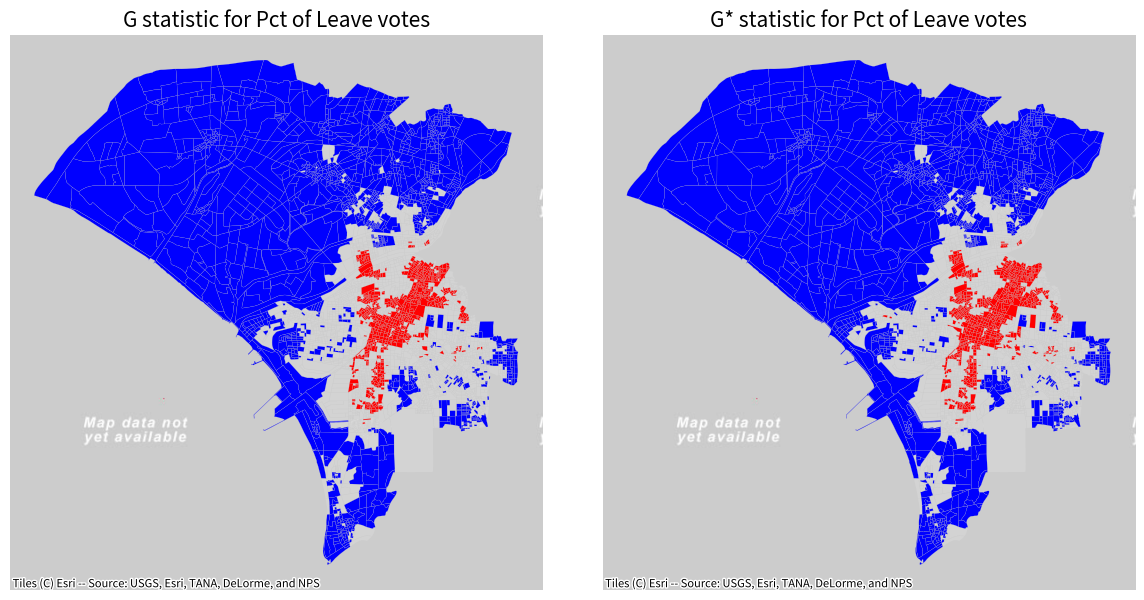

In [83]:
# Set up figure and axes
f, axs = plt.subplots(1, 2, figsize=(12, 6))
# Loop over the two statistics
for g, ax in zip([go_i, go_i_star], axs.flatten()):
    # Generate the statistic's map
    ax = g_map(g, db, ax)
# Tight layout to minimise blank spaces
f.tight_layout()
# Render
plt.show()